#**SA Task with Bi-LSTM and Attention Enhance Model Bangkit's Group C242-PS432**
Developed By FORCECOMM

In [ ]:
!pip install datasets

In [ ]:
!pip install Sastrawi

In [ ]:
 nltk.download('stopwords')
 nltk.download('punkt')
 nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from datasets import load_dataset
ds = load_dataset("carant-ai/indonesian_sentiment_dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds['train']

Dataset({
    features: ['text', 'label_text', 'source', 'split'],
    num_rows: 1030393
})

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional, GlobalMaxPooling1D
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm

In [ ]:
df = pd.DataFrame(ds['train'])

In [ ]:
label_mapping= {
  "negative" : -1,
  "positive" : 1,
  "neutral" : 0
}

In [ ]:
df['label_text'] = df['label_text'].map(label_mapping)

In [ ]:
df = df.drop(['source', 'split'], axis=1)

In [ ]:
df

,text,label_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0
2,lokasi strategis di jalan sumatera bandung . t...,1
3,betapa bahagia nya diri ini saat unboxing pake...,1
4,duh . jadi mahasiswa jangan sombong dong . kas...,-1
...,...,...
1030388,"Pengiriman lebih cepat , packing rapih Dan ba...",1
1030389,I can't login to activated this netbook becaus...,-1
1030390,"barang ok, pengiriman super lambat dn trpaksa ...",-1
1030391,"mantapp,, terima kasih lazadaaa,, tv coocaa 40...",1


In [ ]:
def tokeNstem(text, batch_size=10000):
    texts = str(text)
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        tokenizing = text_to_word_sequence(text, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n', split=" ")
        stop_words = set(stopwords.words('indonesian'))
        stopword_removed = [word for word in tokenizing if word not in stop_words]
        stopword_removed = [word for word in stopword_removed if not word.isdigit()]
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        stemmed_output = ' '.join([stemmer.stem(word) for word in stopword_removed])

    return stemmed_output

In [ ]:
dfs= df.sample(n=15000, random_state=42)

In [ ]:
dfs

,text,label_text
763538,siapa yg mau dapet koin syopi up to 50k nih ti...,0
343143,pertama kali aku coba produk ini pas masih smp...,0
435035,"aku suka sm produk ini krn formulanya ringan,s...",1
546325,setelah dikeluarkan dari tube nya warnanya hij...,1
257084,kecintaanku parah. aku berani pake ini 3hari s...,1
...,...,...
179082,beli ini karena baru pertama kali jerawatan da...,-1
605318,untuk tekstur nya sangat cair sehingga mudah u...,1
304116,abis pulang playdate sama temen perut berasa k...,1
893743,Kenapa saya tidak bisa login ya,-1


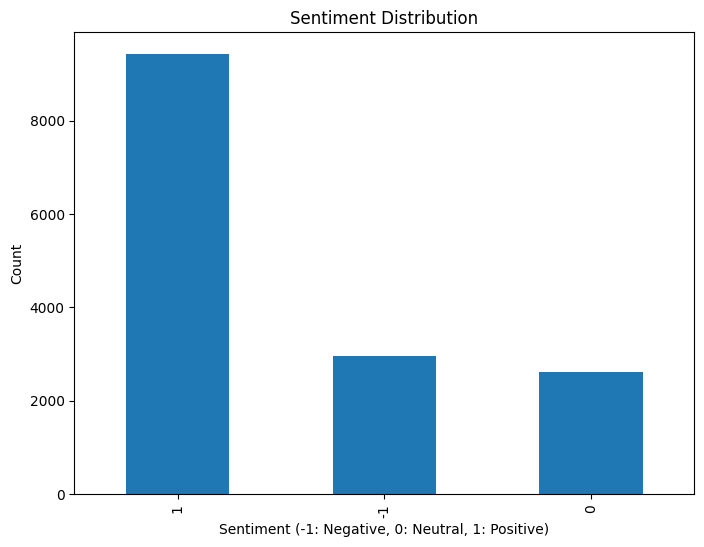

In [ ]:
plt.figure(figsize=(8, 6))
dfs['label_text'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.show()


New class distribution:
label_text
-1    2965
 0    2607
 1    2607
Name: count, dtype: int64


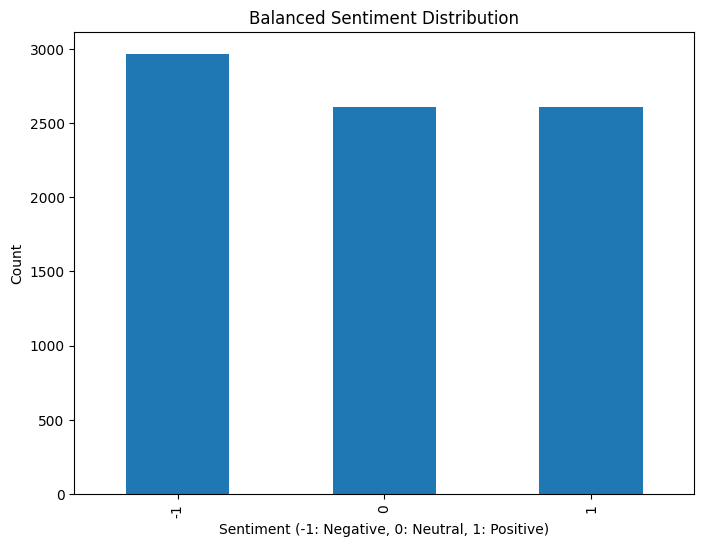

In [ ]:
# Calculate the size of the smallest class
neutral_size = len(dfs[dfs['label_text'] == 0])
negative_size = len(dfs[dfs['label_text'] == -1])
min_size = min(neutral_size, negative_size)

# Get indices of positive samples to keep (randomly sampled)
positive_indices = dfs[dfs['label_text'] == 1].index
indices_to_keep = np.random.choice(positive_indices, size=min_size, replace=False)

# Drop the positive samples that weren't selected
indices_to_drop = positive_indices[~positive_indices.isin(indices_to_keep)]
dfs = dfs.drop(indices_to_drop)

print("\nNew class distribution:")
print(dfs['label_text'].value_counts())

plt.figure(figsize=(8, 6))
dfs['label_text'].value_counts().plot(kind='bar')
plt.title('Balanced Sentiment Distribution')
plt.xlabel('Sentiment (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.show()

In [ ]:
processed_texts = preprocess_indonesian(dfs['text'], batch_size=1000)
dfs['processed_text'] = processed_texts
dfs.to_csv('processed_texts.csv', index=False)

100%|██████████| 9/9 [50:31<00:00, 336.81s/it]


In [ ]:
dfs

,text,label_text,processed_text
763538,siapa yg mau dapet koin syopi up to 50k nih ti...,0,siapa yg mau dapet koin syopi up to k nih tips...
343143,pertama kali aku coba produk ini pas masih smp...,0,pertama kali aku coba produk pas smp karna ema...
435035,"aku suka sm produk ini krn formulanya ringan,s...",1,aku suka sm produk krn formula ringansetelah p...
89467,sukak banget sama sunscreen ini.. sejauh ini d...,1,sukak banget sama sunscreen jauh aku si efek g...
815815,"Barang sdh di terima, kenapa beda dgn pesanan....",-1,barang sdh terima beda dgn pesan pesan yg post...
...,...,...,...
900405,Payah bnyk error nya klo tgl2 lg gajian bisa s...,-1,payah bnyk error nya klo tgl lg gaji hari gabi...
964288,Bolak balik hrs di update.. Muak..,-1,bolak balik hrs update muak
179082,beli ini karena baru pertama kali jerawatan da...,-1,beli baru pertama kali jerawat bom kenal merk ...
605318,untuk tekstur nya sangat cair sehingga mudah u...,1,tekstur nya sangat cair mudah aplikasi timbul ...


In [ ]:
dfs = pd.read_csv("processed_texts.csv")

In [ ]:
MAX_WORDS = 10000
MAX_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(dfs['text'])

sequences = tokenizer.texts_to_sequences(dfs['text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

print("\nExample of tokenized and padded sequence:")
print(f"Original text: {dfs['text'].iloc[0]}")
print(f"Tokenized and padded: {padded_sequences[0]}")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dfs['label_text'])

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    encoded_labels,
    test_size=0.2,
    random_state=42
)


Example of tokenized and padded sequence:
Original text: siapa yg mau dapet koin syopi up to k nih tipsnya askmf
Tokenized and padded: [1491    9   61  354    1    1  109  203  602  430 8562    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [ ]:
def build_model(max_words=MAX_WORDS, max_len=MAX_LEN, embedding_dim=100, lstm_units=64):
    inputs = Input(shape=(max_len,))
    x = Embedding(max_words, embedding_dim)(inputs)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    attention_out = AttentionLayer()(lstm_out)
    x = Dropout(0.2)(attention_out)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:

model = build_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 128)                 │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,093,059 (4.17 MB)

 Trainable params: 1,093,059 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.4057 - loss: 1.0695 - val_accuracy: 0.5346 - val_loss: 0.9550
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.5950 - loss: 0.8937 - val_accuracy: 0.5879 - val_loss: 0.8891
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - accuracy: 0.7109 - loss: 0.7067 - val_accuracy: 0.6093 - val_loss: 0.8908
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.8192 - loss: 0.5017 - val_accuracy: 0.6075 - val_loss: 0.9789
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.8749 - loss: 0.3622 - val_accuracy: 0.6136 - val_loss: 1.1421
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.9147 - loss: 0.2673 - val_accuracy: 0.6056 - val_loss: 1.2287
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 42s 134ms/step - accuracy: 0.9319 - loss: 0.2100 - val_accuracy: 0.5860 - val_loss: 1.6185
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.9503 - loss: 0

In [ ]:

model.save('sentiment_model.h5')
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)


final_accuracy = history.history['accuracy'][-1]
print(f"\nFinal training accuracy: {final_accuracy*100:.2f}%")


Final training accuracy: 96.68%
